# Based on our custom MIMIC language model, train a classifier

Make sure mimic_nlp_lm has been run first and sucessfully completed. That notebook builds the language model that allows classificiation to occur efficiently.

## Create a classifier to predict Length of Stay (LOS)

Steps:
1. Load clinical Notes
1. Load Admissions data
1. Calculate Length of Stay
1. Join Admissions data with Notes data (on HADM_ID) - Columns needed for classifier: LOS, TEXT

Would also be nice to see a graphical summary of LOS.

In [12]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc
import altair as alt

Setup filenames and paths

In [13]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'los_cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'los_cl_head'
cycles_file = base_path/'cl_num_iterations.pickle'
enc_file = 'mimic_fine_tuned_enc'
ft_file = 'los_cl_fine_tuned_'

Setup parameters for models

In [14]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
# for language model building - not sure how this will translate to classifier
# batch size of 128 GPU uses 14GB RAM
# batch size of 96 GPU uses 9GB RAM
# batch size of 48 GPU uses 5GB RAM
bs=96

In [15]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


Since seed is different, this should be quite different than the language model dataset.

Should I show details on how many records are in language model dataset?

In [24]:
notes_df = orig_df[orig_df.HADM_ID.notnull()].copy()
notes_df.HADM_ID = notes_df.HADM_ID.astype(int)
notes_df.shape

(1851344, 11)

In [17]:
notes_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [18]:
print('Loading ADMISSIONS.csv')
a_orig = pd.read_csv(admissions_file, low_memory=False, memory_map=True)
a_orig.shape

Loading ADMISSIONS.csv


(58976, 19)

In [19]:
a_df = a_orig[['HADM_ID', 'ADMITTIME', 'DISCHTIME']].copy()
#pd.to_datetime('2014-04-09T152959.999993-0500', utc=True)
# passing format just to make sure conversion doesn't mess something up
a_df['admittime'] = pd.to_datetime(a_df.ADMITTIME, format='%Y-%m-%d %H:%M:%S')
a_df['dischtime'] = pd.to_datetime(a_df.DISCHTIME, format='%Y-%m-%d %H:%M:%S')
a_df['los'] = (a_df['dischtime'] - a_df['admittime']).astype('timedelta64[D]')
# there are 98 admissions where length of stay is negative. change to 0
a_df.loc[a_df.los < 0, 'los'] = 0
a_df.head()

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los
0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0
1,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,2153-09-03 07:15:00,2153-09-08 19:10:00,5.0
2,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,2157-10-18 19:34:00,2157-10-25 14:00:00,6.0
3,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,2139-06-06 16:14:00,2139-06-09 12:48:00,2.0
4,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,2160-11-02 02:06:00,2160-11-05 14:55:00,3.0


### Histogram of Length of Stay

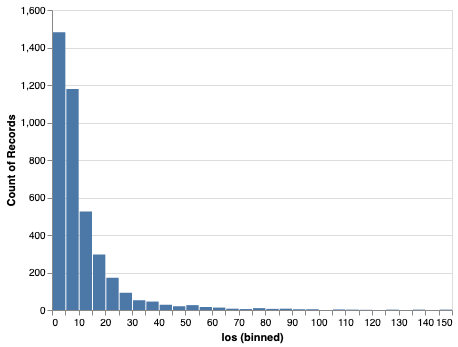

In [20]:
alt.Chart(a_df.head(4000)).mark_bar().encode(
    alt.X('los',
         bin=alt.BinParams(maxbins=50)),
    y='count()',
)

In [21]:
# make sure we only keep rows with notes
combined_df = pd.merge(a_df, notes_df, on='HADM_ID', how='right')

# passing format just to make sure conversion doesn't mess something up
combined_df['charttime'] = pd.to_datetime(combined_df.CHARTTIME, format='%Y-%m-%d %H:%M:%S')
combined_df = combined_df['HADM_ID', 'admittime', 'dischtime', 'los', 'charttime', 'TEXT']
combined_df.rename(columns={"HADM_ID": "hadm_id", "TEXT": "text"})

In [22]:
combined_df.shape

(1851344, 17)

In [23]:
# these should all be zero
print(combined_df[combined_df.los.isnull()].shape)
print(combined_df[combined_df.HADM_ID.isnull()].shape)
print(combined_df[combined_df.TEXT.isnull()].shape)

(0, 17)
(0, 17)
(0, 17)


In [25]:
combined_df.head()

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,charttime
0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0,12144,22,2196-04-10,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2196-4-9**] Discharg...,NaT
1,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0,158364,22,2196-04-09,NaN,NaN,ECG,Report,NaN,NaN,Normal sinus rhythm. Non-diagnostic repolariza...,NaT
2,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0,158365,22,2196-04-09,NaN,NaN,ECG,Report,NaN,NaN,Normal sinus rhythm without diagnostic abnorma...,NaT
3,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0,754366,22,2196-04-10,2196-04-10 23:52:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2196-4-10**] 11:52 PM\n CHEST (PORTABLE AP)...,2196-04-10 23:52:00
4,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0,754332,22,2196-04-09,2196-04-09 10:19:00,NaN,Radiology,CT HEAD W/O CONTRAST,NaN,NaN,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...,2196-04-09 10:19:00


### As an alternative - how about using notes from day 1 of stay to predict LOS?


    For each admission
        do they have notes on day 1 of stay

In [88]:
combined_df.dtypes

HADM_ID                 int64
ADMITTIME              object
DISCHTIME              object
admittime      datetime64[ns]
dischtime      datetime64[ns]
los                   float64
ROW_ID                  int64
SUBJECT_ID              int64
CHARTDATE              object
CHARTTIME              object
STORETIME              object
CATEGORY               object
DESCRIPTION            object
CGID                  float64
ISERROR               float64
TEXT                   object
charttime      datetime64[ns]
dtype: object

In [89]:
combined_df[combined_df.HADM_ID == 100006]

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,charttime
30414,100006,2108-04-06 15:49:00,2108-04-18 17:18:00,2108-04-06 15:49:00,2108-04-18 17:18:00,12.0,148403,9895,2108-04-06,NaN,NaN,ECG,Report,NaN,NaN,Sinus tachycardia\nLeft axis deviation - anter...,NaT
30415,100006,2108-04-06 15:49:00,2108-04-18 17:18:00,2108-04-06 15:49:00,2108-04-18 17:18:00,12.0,1392732,9895,2108-04-07,2108-04-07 05:07:00,2108-04-07 05:24:00,Nursing/other,Report,21570.0,NaN,7p to 7a Micu Progress Note\n\nNeuro - Remains...,2108-04-07 05:07:00
30416,100006,2108-04-06 15:49:00,2108-04-18 17:18:00,2108-04-06 15:49:00,2108-04-18 17:18:00,12.0,55972,9895,2108-04-18,NaN,NaN,Discharge summary,Addendum,NaN,NaN,"Name: [**Known lastname 470**], [**Known firs...",NaT
30417,100006,2108-04-06 15:49:00,2108-04-18 17:18:00,2108-04-06 15:49:00,2108-04-18 17:18:00,12.0,783338,9895,2108-04-06,2108-04-06 11:45:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2108-4-6**] 11:45 AM\n CHEST (PORTABLE AP) ...,2108-04-06 11:45:00


In [90]:
h = 100006
#for h in combined_df.HADM_ID.unique():
combined_df[(combined_df.HADM_ID == h) & 
            (combined_df.charttime >= combined_df.admittime) &
            (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24)))]

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,charttime
30415,100006,2108-04-06 15:49:00,2108-04-18 17:18:00,2108-04-06 15:49:00,2108-04-18 17:18:00,12.0,1392732,9895,2108-04-07,2108-04-07 05:07:00,2108-04-07 05:24:00,Nursing/other,Report,21570.0,NaN,7p to 7a Micu Progress Note\n\nNeuro - Remains...,2108-04-07 05:07:00


### Histogram of number of notes by Hospital Admission - 10% random sample

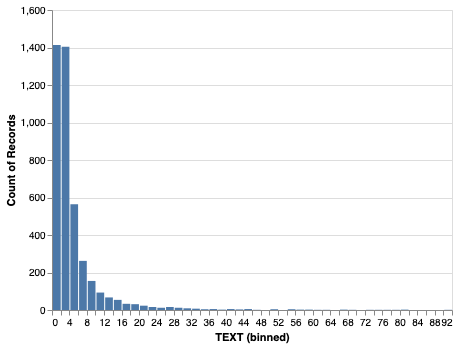

In [91]:
alt.Chart(
    combined_df.groupby('HADM_ID', as_index=False).TEXT.count().sample(frac=.1, random_state=seed)
).mark_bar().encode(
    alt.X('TEXT', bin=alt.BinParams(maxbins=50)),
    y='count()',
)

### Scatter plot of Number of Notes vs Length of Stay

In [92]:
combined_df[['HADM_ID', 'los']].drop_duplicates().shape            #42,195
combined_df.groupby('HADM_ID', as_index=False).TEXT.count().shape  #42,195

(42195, 2)

In [93]:
los_v_num_notes = pd.merge(combined_df[['HADM_ID', 'los']].drop_duplicates(), 
          combined_df.groupby('HADM_ID', as_index=False).TEXT.count(),
          on='HADM_ID')
los_v_num_notes.shape

(42195, 3)

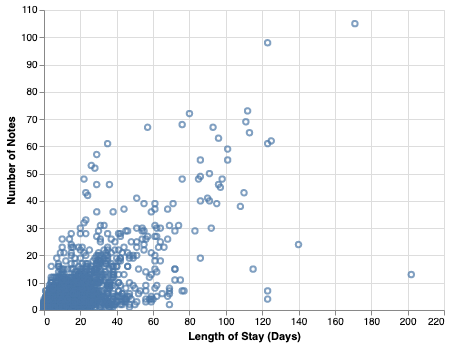

In [94]:
alt.Chart(los_v_num_notes.sample(frac=.1, random_state=seed)).mark_point().encode(
    x=alt.X('los', axis=alt.Axis(title='Length of Stay (Days)')),
    y=alt.Y('TEXT', axis=alt.Axis(title='Number of Notes')))

In [95]:

combined_df.groupby('HADM_ID')
    

In [96]:
df[df.groupby('session')['url'].transform(lambda x : x.isin(valid_urls).any())]

KeyError: 'session'

In [ ]:
combined_df[(combined_df.charttime >= combined_df.admittime) &
            (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24)))].sort_values('HADM_ID')

fd_df = combined_df[(combined_df.charttime >= combined_df.admittime) &
                    (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24)))].sort_values('HADM_ID')
len(fd_df.HADM_ID.unique())

### Continuing on with Deep Learning

In [8]:
if os.path.isfile(base_path/lm_file):
    print('loading existing language model')
    lm = load_data(base_path, lm_file, bs=bs)
else:
    print('ERROR: language model file not found.')

loading existing language model


#### This is a very CPU and RAM intensive process - no GPU involved

In [9]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
else:
    # do I need a vocab here? test with and without...
    data_cl = (TextList.from_df(df, base_path, cols='TEXT', vocab=lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set see for repeatability
               .label_from_df(cols='los')
               #building classifier to automatically determine DESCRIPTION
               .databunch(bs=bs))
    data_cl.save(filename)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
FNA, ANY LOCATION, critical care attending note, PELVIS, EARLY OB US, FDG TUMOR IMAGING, Speech/Swallow Follow Up...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [10]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


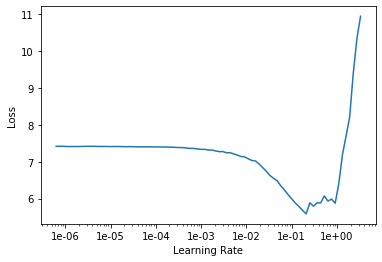

In [12]:
learn.recorder.plot()

Change learning rate based on results from the above plot

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Now need to fine tune

In [ ]:
learn.unfreeze()